<a href="https://colab.research.google.com/github/KWSantos/MLP_Model/blob/main/MLP_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importações

In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Dataset

### Extração do Dataset

### Leitura do Dataset

In [ ]:
dataset_train = pd.read_csv('pulsar_data_train.csv')
dataset_test = pd.read_csv('pulsar_data_test.csv')

In [ ]:
dataset_train.shape
# https://www.kaggle.com/code/mohamedmosaadhadia/predicting-pulsar-stars  Codigo base

(12528, 9)

In [ ]:
dataset_train.columns=['Mean','SD','Kurtosis','Skewness','DM_SNR_Mean','DM_SMR_SD','DM-SNR Kurtosis','DM-SNR Skewness','Target_class']
dataset_test.columns=['Mean','SD','Kurtosis','Skewness','DM_SNR_Mean','DM_SMR_SD','DM-SNR Kurtosis','DM-SNR Skewness','Target_class']
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Mean             12528 non-null  float64
 1   SD               12528 non-null  float64
 2   Kurtosis         10793 non-null  float64
 3   Skewness         12528 non-null  float64
 4   DM_SNR_Mean      12528 non-null  float64
 5   DM_SMR_SD        11350 non-null  float64
 6   DM-SNR Kurtosis  12528 non-null  float64
 7   DM-SNR Skewness  11903 non-null  float64
 8   Target_class     12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


In [ ]:
dataset_train.duplicated().sum()

0

In [ ]:
dataset_train.isnull().sum()

,0
Mean,0
SD,0
Kurtosis,1735
Skewness,0
DM_SNR_Mean,0
DM_SMR_SD,1178
DM-SNR Kurtosis,0
DM-SNR Skewness,625
Target_class,0


<ipython-input-7-00342b749178>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')


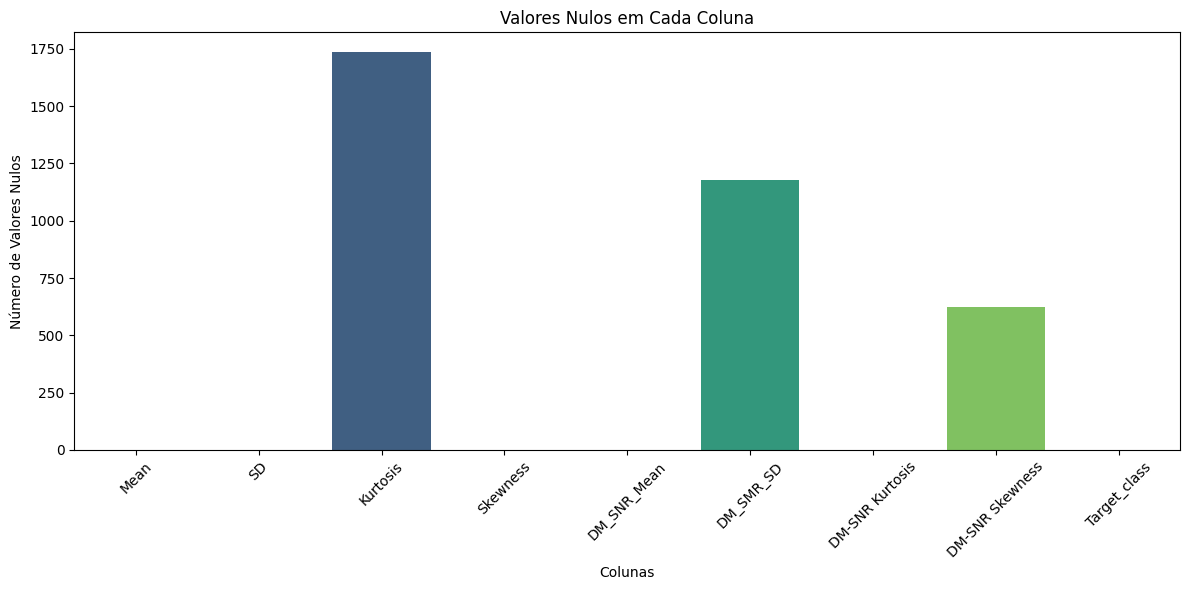

In [ ]:
missing_values = dataset_train.isnull().sum()
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.title('Valores Nulos em Cada Coluna')
plt.xlabel('Colunas')
plt.ylabel('Número de Valores Nulos')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('valores_nulos.png')
plt.show()

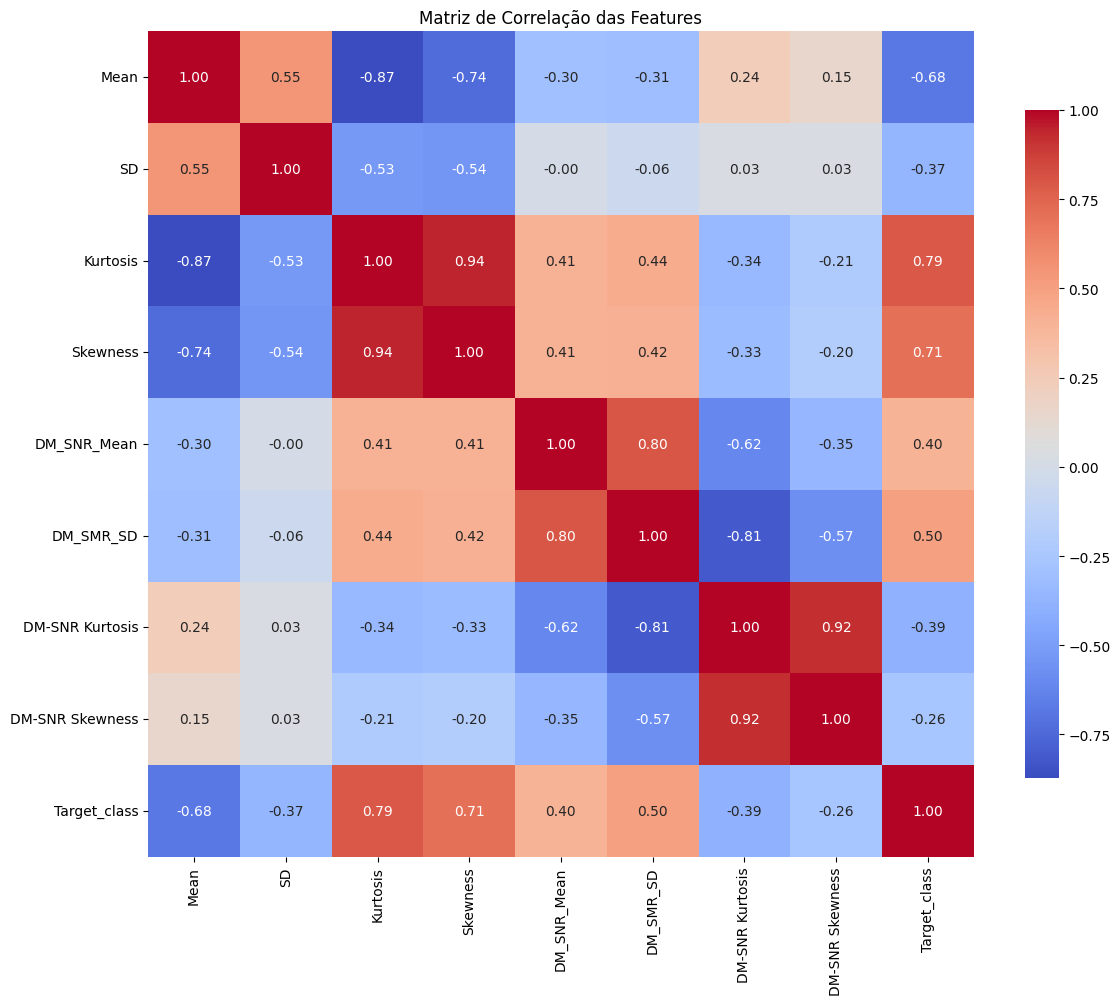

In [ ]:
correlation_matrix = dataset_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação das Features')
plt.tight_layout()

plt.savefig('matriz_correlacao.png')
plt.show()

# Rede Neural


In [ ]:
class MultiLayerPerceptron:
    def __init__(self, x: np.ndarray, y: np.ndarray, hidden_neurons1: int = 10, hidden_neurons2: int = 10, output_neurons: int = 1):
        np.random.seed(8)
        self.x = x
        self.y = y
        self.hidden_neurons1 = hidden_neurons1
        self.hidden_neurons2 = hidden_neurons2
        self.output_neurons = output_neurons
        self.input_neurons = self.x.shape[1]

        self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons1) / np.sqrt(self.input_neurons)
        self.B1 = np.zeros((1, self.hidden_neurons1))
        self.W2 = np.random.randn(self.hidden_neurons1, self.hidden_neurons2) / np.sqrt(self.hidden_neurons1)
        self.B2 = np.zeros((1, self.hidden_neurons2))
        self.W3 = np.random.randn(self.hidden_neurons2, self.output_neurons) / np.sqrt(self.hidden_neurons2)
        self.B3 = np.zeros((1, self.output_neurons))
        self.z1 = 0
        self.f1 = 0
        self.z2 = 0
        self.f2 = 0
        self.output = 0

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.z1 = x.dot(self.W1) + self.B1
        self.f1 = np.tanh(self.z1)

        self.z2 = self.f1.dot(self.W2) + self.B2
        self.f2 = np.tanh(self.z2)

        z3 = self.f2.dot(self.W3) + self.B3
        self.output = 1 / (1 + np.exp(-z3))
        return self.output

    def loss(self) -> float:
        predictions = self.output.flatten()
        labels = self.y.flatten()
        return -np.mean(labels * np.log(predictions + 1e-12) + (1 - labels) * np.log(1 - predictions + 1e-12))

    def backpropagation(self, learning_rate: float) -> None:
        delta3 = self.output - self.y.reshape(-1, 1)

        dW3 = self.f2.T.dot(delta3) / self.x.shape[0]
        dB3 = np.sum(delta3, axis=0, keepdims=True) / self.x.shape[0]

        delta2 = delta3.dot(self.W3.T) * (1 - np.power(self.f2, 2))
        dW2 = self.f1.T.dot(delta2) / self.x.shape[0]
        dB2 = np.sum(delta2, axis=0, keepdims=True) / self.x.shape[0]

        delta1 = delta2.dot(self.W2.T) * (1 - np.power(self.f1, 2))
        dW1 = self.x.T.dot(delta1) / self.x.shape[0]
        dB1 = np.sum(delta1, axis=0, keepdims=True) / self.x.shape[0]

        self.W1 -= learning_rate * dW1
        self.W2 -= learning_rate * dW2
        self.W3 -= learning_rate * dW3
        self.B1 -= learning_rate * dB1
        self.B2 -= learning_rate * dB2
        self.B3 -= learning_rate * dB3


    def show_plot(self, predictions):
        if self.x.shape[1] == 2:
            plt.scatter(self.x[:, 0], self.x[:, 1], s=50, c=predictions, cmap='cool', alpha=0.7)
            plt.show()

    def fit(self, epochs: int, lr: float, show_plot: bool = False):
        for epoch in range(epochs):
            outputs = self.forward(self.x)
            loss = self.loss()
            self.backpropagation(lr)

            predictions = (outputs > 0.5).astype(int)
            correct = (predictions.flatten() == self.y.flatten()).sum()
            accuracy = correct / self.y.shape[0]

            if int((epoch + 1) % (epochs / 10)) == 0 or epoch == epochs - 1:
                print(f'Epoch: [{epoch + 1} / {epochs}]  Accuracy: {accuracy:.3f} Loss: {loss:.5f}')
                if show_plot:
                    self.show_plot(predictions)
        print(f'Epoch: [{epoch + 1} / {epochs}]  Accuracy: {accuracy:.3f} Loss: {loss:.5f}')
        return predictions

    def predict(self, x: np.ndarray) -> np.ndarray:
        outputs = self.forward(x)
        predictions = (outputs > 0.5).astype(int)
        return predictions.flatten()

# Primeiro Teste

In [ ]:
# Definindo variáveis independentes e dependentes
X = dataset_train.fillna(dataset_train.mean()).to_numpy()[:, 0:8]
Y = dataset_train.fillna(dataset_train.mean()).to_numpy()[:, 8]
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train[0:5])
# # Criar e treinar o modelo Random Forest
# model = RandomForestClassifier(random_state=42)
# model.fit(X_train, Y_train)

# Obter a importância das features
# importances = model.feature_importances_
# feature_names = X.columns

# # Criar um DataFrame para visualizar a importância das features
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(12, 6))
# sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# plt.title('Importância das Features')
# plt.xlabel('Importância')
# plt.ylabel('Features')
# plt.tight_layout()

# # Salvar o gráfico
# plt.savefig('importancia_features.png')
# plt.show()

[[ 1.10664062e+02  4.65584776e+01  4.78547749e-01  1.25224384e-01
   3.01254181e+00  1.96568559e+01  8.03827452e+00  1.05525779e+02]
 [ 1.28031250e+02  4.01477618e+01  4.78547749e-01  6.55912248e-01
   4.74832776e+00  2.36203466e+01  5.83096493e+00  3.76465745e+01]
 [ 1.24484375e+02  4.70290775e+01  7.07299970e-02  1.63260571e-01
   1.32525084e+00  1.47166799e+01  1.29711165e+01  1.83823205e+02]
 [ 1.07554688e+02  4.57070852e+01  3.80769847e-01  7.99653036e-01
   1.98160535e+00  1.43291922e+01  1.04404616e+01  1.34473229e+02]
 [ 1.32703125e+02  4.30013371e+01 -1.07772078e-01  4.56369438e-01
   2.28260870e+00  1.83921078e+01  9.25412999e+00  9.41677250e+01]]


In [ ]:
from google.colab import files
files.download('confusion_matrix.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset_train.head()

,Mean,SD,Kurtosis,Skewness,DM_SNR_Mean,DM_SMR_SD,DM-SNR Kurtosis,DM-SNR Skewness,Target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [ ]:
missing_data_rows = dataset_train[dataset_train.isnull().any(axis=1)]
print(missing_data_rows)

             Mean         SD  Kurtosis  Skewness  DM_SNR_Mean  DM_SMR_SD  \
3      156.398438  48.865942 -0.215989 -0.171294    17.471572        NaN   
5      121.007812  47.176944  0.229708  0.091336     2.036789        NaN   
6       79.343750  42.402174  1.063413  2.244377   141.641304        NaN   
9      109.156250  47.002234  0.394182  0.190296     4.578595        NaN   
13     128.734375  48.695560       NaN  0.307803     5.307692  25.162295   
...           ...        ...       ...       ...          ...        ...   
12503  132.335938  52.273362 -0.095982 -0.417207     4.736622        NaN   
12504   85.015625  36.717244       NaN  2.503142     3.262542  21.981437   
12506  113.750000  51.916098  0.215305 -0.216608     1.678930  11.105255   
12513  127.609375  53.509379       NaN -0.564330     0.527592   8.985407   
12524  115.617188  46.784600  0.218177  0.226757     6.140468        NaN   

       DM-SNR Kurtosis  DM-SNR Skewness  Target_class  
3             2.958066         

In [ ]:
dataset_train = dataset_train.fillna(dataset_train.mean())
dataset_test = dataset_test.fillna(dataset_test.mean())

In [ ]:
x = dataset_train.to_numpy()[:, 0:8]
y = dataset_train.to_numpy()[:, 8]

unique = np.unique(y, return_counts = True)
for label, qt_label in zip(unique[0], unique[1]):
    print(f'Label: {label}\t Counts: {qt_label}')

Label: 0.0	 Counts: 11375
Label: 1.0	 Counts: 1153


In [ ]:
print(f'{x.shape = }, {y.shape = }')

x.shape = (12528, 8), y.shape = (12528,)


In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_scaled[0:5])
print(Y_train[0:5])

[[0.5700875  0.32337596 0.22600651 0.02742902 0.01338836 0.12011961
  0.29049503 0.0900917 ]
 [0.66451448 0.22622392 0.22600651 0.03502183 0.0216901  0.15886912
  0.23140053 0.0331914 ]
 [0.6452298  0.33050773 0.18442446 0.02797322 0.00531855 0.07182142
  0.422558   0.15572515]
 [0.55318155 0.31047342 0.21603685 0.03707839 0.0084577  0.0680331
  0.35480683 0.11435713]
 [0.68991589 0.2694688  0.16622397 0.03216687 0.00989731 0.10775466
  0.32304614 0.08057072]]
[0. 0. 0. 0. 0.]


In [ ]:
mlp = MultiLayerPerceptron(X_scaled, Y_train, hidden_neurons1=16, hidden_neurons2=16, output_neurons=1)
mlp.fit(epochs=1000, lr=0.1, show_plot=False)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
# x_test = x_test.to_numpy()[:, 0:8]

# Prever os valores do conjunto de teste
y_pred = mlp.predict(X_test)

In [ ]:
# Calcular as métricas
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, zero_division=1)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
auc = roc_auc_score(Y_test, y_pred)

# Exibir as métricas
print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'AUC-ROC: {auc:.2f}')

Acurácia: 0.98
Precisão: 0.92
Recall: 0.71
F1-Score: 0.80
AUC-ROC: 0.85


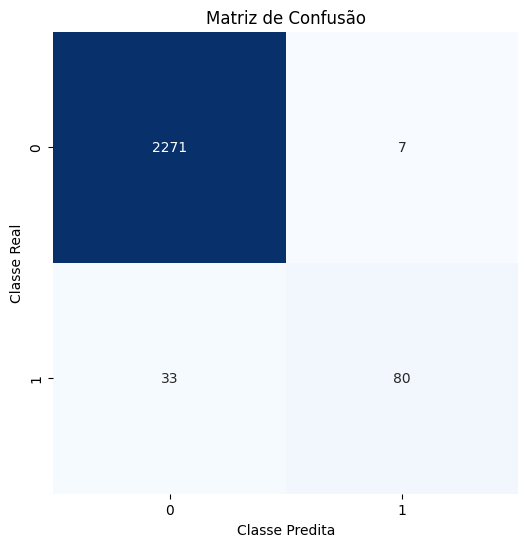

In [ ]:
from sklearn.metrics import confusion_matrix

# Criar a matriz de confusão
cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')

# Salvar a figura como arquivo PNG
plt.savefig("confusion_matrix.png")

# Exibir a matriz de confusão
plt.show()

# Algoritmo Genético Para Otimização dos Paramêtros da Rede

In [ ]:
epochs = [50, 100, 150, 200, 500, 1000]
learning_rate = [0.5, 0.1, 0.05, 0.01, 0.005]
hidden_neurons1 = [2, 4, 8, 16, 32, 64]
hidden_neurons2 = [2, 4, 8, 16, 32, 64]
fitness_cache = {}

In [ ]:
def fitness(chromosome: list) -> float:
    chromosome_tuple = tuple(chromosome)
    if chromosome_tuple in fitness_cache:
        return fitness_cache[chromosome_tuple]
    mlp = MultiLayerPerceptron(X_train, Y_train, hidden_neurons1=chromosome[2], hidden_neurons2=chromosome[3], output_neurons=1)
    mlp.fit(epochs=chromosome[0], lr=chromosome[1], show_plot=False)
    y_pred = mlp.predict(X_test)
    f1 = f1_score(Y_test, y_pred)
    fitness_cache[chromosome_tuple] = f1
    print(f'Fitness: {f1}')
    print(f'Epochs: {chromosome[0]}')
    print(f'Learning Rate: {chromosome[1]}')
    print(f'Hidden Neurons 1: {chromosome[2]}')
    print(f'Hidden Neurons 2: {chromosome[3]}')
    print()
    return f1

In [ ]:
class Chromosome():
    def __init__(self, characteristics):
        self.characteristics = characteristics
        self.fitness = fitness(characteristics)

In [ ]:
# vetor de características: [épocas, taxa de aprendizagem, neurônios da camada oculta 1, neurônios da camada oculta 2]
# população: [vetor de características1, ..., vetor de características10]
population = []
unique_individuals = set()
while len(population) < 10:
    characteristics = [
        random.choice(epochs),
        random.choice(learning_rate),
        random.choice(hidden_neurons1),
        random.choice(hidden_neurons2)
    ]
    characteristics_tuple = tuple(characteristics)
    if characteristics_tuple not in unique_individuals:
        unique_individuals.add(characteristics_tuple)
        population.append(Chromosome(characteristics))

Fitness: 0.6411764705882353
Epochs: 200
Learning Rate: 0.1
Hidden Neurons 1: 4
Hidden Neurons 2: 2

Fitness: 0.0
Epochs: 500
Learning Rate: 0.005
Hidden Neurons 1: 4
Hidden Neurons 2: 4

Fitness: 0.0
Epochs: 100
Learning Rate: 0.01
Hidden Neurons 1: 8
Hidden Neurons 2: 8

Fitness: 0.41904761904761906
Epochs: 1000
Learning Rate: 0.005
Hidden Neurons 1: 64
Hidden Neurons 2: 32

Fitness: 0.6382978723404256
Epochs: 100
Learning Rate: 0.5
Hidden Neurons 1: 64
Hidden Neurons 2: 2

Fitness: 0.2446043165467626
Epochs: 1000
Learning Rate: 0.005
Hidden Neurons 1: 4
Hidden Neurons 2: 8

Fitness: 0.6862745098039216
Epochs: 1000
Learning Rate: 0.005
Hidden Neurons 1: 32
Hidden Neurons 2: 32

Fitness: 0.0
Epochs: 150
Learning Rate: 0.01
Hidden Neurons 1: 16
Hidden Neurons 2: 4

Fitness: 0.00851063829787234
Epochs: 200
Learning Rate: 0.05
Hidden Neurons 1: 8
Hidden Neurons 2: 8

Fitness: 0.7733333333333333
Epochs: 50
Learning Rate: 0.005
Hidden Neurons 1: 32
Hidden Neurons 2: 64



In [ ]:
def tournament_selection(population: list, k=2) -> Chromosome:
    tournament = random.sample(population, k)
    return max(tournament, key=lambda individual: individual.fitness)

In [ ]:
def crossover(parent1: Chromosome, parent2: Chromosome) -> tuple:
    crossover_point = random.randint(1, len(parent1.characteristics) - 1)
    child1_genes = parent1.characteristics[:crossover_point] + parent2.characteristics[crossover_point:]
    child2_genes = parent2.characteristics[:crossover_point] + parent1.characteristics[crossover_point:]

    return Chromosome(child1_genes), Chromosome(child2_genes)

In [ ]:
import copy

def mutate(individual: Chromosome, mutation_rate) -> Chromosome:
    new_individual = copy.deepcopy(individual)

    for i in range(len(new_individual.characteristics)):
        if random.randint(1, 100) < mutation_rate:
            if i == 0:
                new_individual.characteristics[i] = random.choice(epochs)
            elif i == 1:
                new_individual.characteristics[i] = random.choice(learning_rate)
            elif i == 2:
                new_individual.characteristics[i] = random.choice(hidden_neurons1)
            elif i == 3:
                new_individual.characteristics[i] = random.choice(hidden_neurons2)
    new_individual.fitness = fitness(new_individual.characteristics)
    return new_individual

In [ ]:
bests = []
worsts = []
average_fitnesses = []

def genetic_algorithm(generations: int, mutation_rate: int, population: list):
    print("População Inicial:")
    for individual in population:
        print(individual.characteristics)
        print(individual.fitness)
    print()
    for generation in range(generations):
        for _ in range(2):
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            while parent1 == parent2:
                parent2 = tournament_selection(population)

            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)

            population.extend([child1, child2])
        population = sorted(population, key=lambda individual: individual.fitness, reverse=True)
        population = population[:20]
        print(f"População na Geração {generation + 1}:")
        for individual in population:
            print(individual.characteristics)
            print(individual.fitness)
        print()
        best_individual = max(population, key=lambda individual: individual.fitness)
        worst_individual = min(population, key=lambda individual: individual.fitness)
        bests.append({
            'generation': generation + 1,
            'fitness': best_individual.fitness,
            'characteristics': best_individual.characteristics
        })
        worsts.append({
            'generation': generation + 1,
            'fitness': worst_individual.fitness,
            'characteristics': worst_individual.characteristics
        })

        avg_fitness = sum(individual.fitness for individual in population) / len(population)
        average_fitnesses.append(avg_fitness)

        print(f"Geração {generation+1}: Best Fitness: {best_individual.fitness:.4f}, Worst Fitness: {worst_individual.fitness:.4f}")
        print()

    return best_individual

In [ ]:
generations = 20
mutation_rate = 5
best_individual = genetic_algorithm(generations, mutation_rate=mutation_rate, population=population)

População Inicial:
[200, 0.1, 4, 2]
0.6411764705882353
[500, 0.005, 4, 4]
0.0
[100, 0.01, 8, 8]
0.0
[1000, 0.005, 64, 32]
0.41904761904761906
[100, 0.5, 64, 2]
0.6382978723404256
[1000, 0.005, 4, 8]
0.2446043165467626
[1000, 0.005, 32, 32]
0.6862745098039216
[150, 0.01, 16, 4]
0.0
[200, 0.05, 8, 8]
0.00851063829787234
[50, 0.005, 32, 64]
0.7733333333333333

Fitness: 0.5843828715365239
Epochs: 50
Learning Rate: 0.5
Hidden Neurons 1: 64
Hidden Neurons 2: 2

Fitness: 0.7423822714681441
Epochs: 100
Learning Rate: 0.005
Hidden Neurons 1: 32
Hidden Neurons 2: 64

Fitness: 0.77088948787062
Epochs: 200
Learning Rate: 0.005
Hidden Neurons 1: 32
Hidden Neurons 2: 64

Fitness: 0.0
Epochs: 50
Learning Rate: 0.05
Hidden Neurons 1: 8
Hidden Neurons 2: 8

Fitness: 0.0
Epochs: 50
Learning Rate: 0.05
Hidden Neurons 1: 64
Hidden Neurons 2: 8

População na Geração 1:
[50, 0.005, 32, 64]
0.7733333333333333
[200, 0.005, 32, 64]
0.77088948787062
[100, 0.005, 32, 64]
0.7423822714681441
[1000, 0.005, 32, 32]


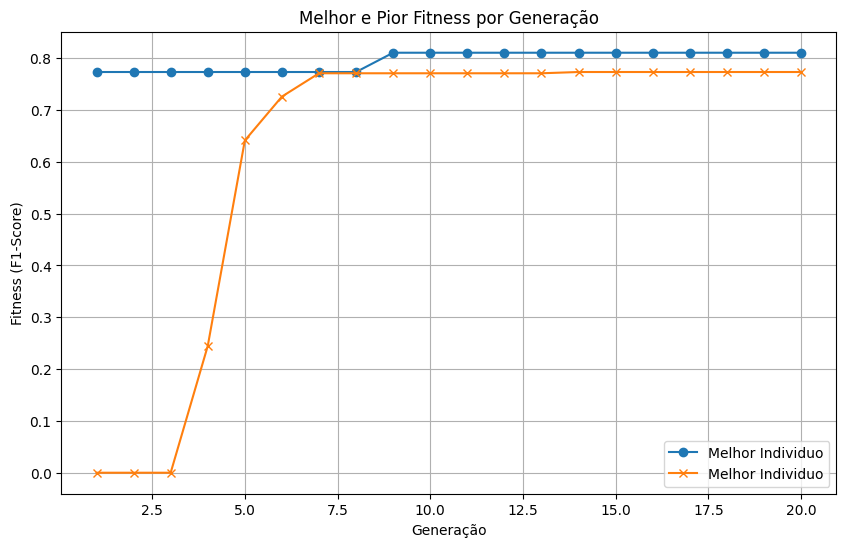

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([b['generation'] for b in bests], [b['fitness'] for b in bests], label='Melhor Individuo', marker='o')
plt.plot([w['generation'] for w in worsts], [w['fitness'] for w in worsts], label='Melhor Individuo', marker='x')
plt.xlabel('Generação')
plt.ylabel('Fitness (F1-Score)')
plt.title('Melhor e Pior Fitness por Generação')
plt.legend()
plt.grid(True)
plt.show()

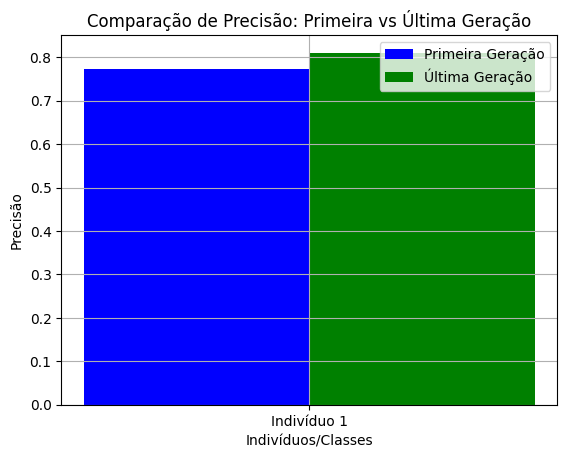

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

first_gen_fitness = [b['fitness'] for b in bests if b['generation'] == 1] # Extract only the fitness values
last_gen_fitness = [b['fitness'] for b in bests if b['generation'] == generations]

ind = np.arange(len(first_gen_fitness))
width = 0.35
fig, ax = plt.subplots()

bar1 = ax.bar(ind - width/2, first_gen_fitness, width, label='Primeira Geração', color='blue')
bar2 = ax.bar(ind + width/2, last_gen_fitness, width, label='Última Geração', color='green')
ax.set_title('Comparação de Precisão: Primeira vs Última Geração')
ax.set_xlabel('Indivíduos/Classes')
ax.set_ylabel('Precisão')
ax.legend()
ax.set_xticks(ind)
ax.set_xticklabels([f'Indivíduo {i+1}' for i in ind])
plt.grid(True)
plt.show()

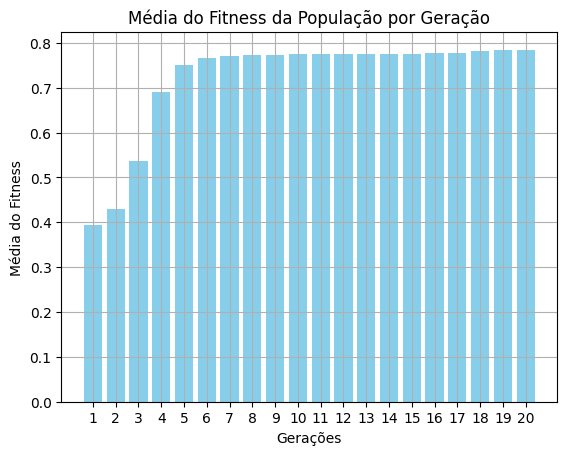

In [ ]:
generations = list(range(1, len(average_fitnesses) + 1))

plt.bar(generations, average_fitnesses, color='skyblue')

plt.title('Média do Fitness da População por Geração')
plt.xlabel('Gerações')
plt.ylabel('Média do Fitness')
plt.xticks(generations)
plt.grid(True)
plt.show()

In [ ]:
generations = []
fitness_values = []
epochs_list = []
learning_rate_list = []
hidden_neurons1_list = []
hidden_neurons2_list = []

characteristics_keys = ['epochs', 'learning_rate', 'hidden_neurons1', 'hidden_neurons2']

for best in bests:
    generations.append(best['generation'])
    fitness_values.append(best['fitness'])

    for i, key in enumerate(characteristics_keys):
        if key == 'epochs':
            epochs_list.append(best['characteristics'][i])
        elif key == 'learning_rate':
            learning_rate_list.append(best['characteristics'][i])
        elif key == 'hidden_neurons1':
            hidden_neurons1_list.append(best['characteristics'][i])
        elif key == 'hidden_neurons2':
            hidden_neurons2_list.append(best['characteristics'][i])

df = pd.DataFrame({
    'Geração': generations,
    'Fitness (F1)': fitness_values,
    'Épocas': epochs_list,
    'Taxa de Aprendizado': learning_rate_list,
    'Neurônios Camada 1': hidden_neurons1_list,
    'Neurônios Camada 2': hidden_neurons2_list
})

print(df)

    Geração  Fitness (F1)  Épocas  Taxa de Aprendizado  Neurônios Camada 1  \
0         1      0.773333      50                0.005                  32   
1         2      0.773333      50                0.005                  32   
2         3      0.773333      50                0.005                  32   
3         4      0.773333      50                0.005                  32   
4         5      0.773333      50                0.005                  32   
5         6      0.773333      50                0.005                  32   
6         7      0.773333      50                0.005                  32   
7         8      0.773333      50                0.005                  32   
8         9      0.810552     200                0.010                  32   
9        10      0.810552     200                0.010                  32   
10       11      0.810552     200                0.010                  32   
11       12      0.810552     200                0.010          